# **Final Project - Group 3**
## **"Self-Driving Car"**
Implementing end to end learning for self-driving cars using simulator based on Nvidia Paper

In [2]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzip data from drive

!unzip drive/MyDrive/Classroom/Brainster/IMG.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2021_07_13_22_38_52_665.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_754.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_845.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_934.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_024.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_113.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_206.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_294.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_385.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_472.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_563.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_653.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_740.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_829.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_921.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_54_008.jpg  
  inflating: data/IMG

# **Importing Libraries**

In [4]:
import numpy as np
import pandas as pd
import os
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import random
from sklearn.utils import shuffle
import tensorflow as tf
from random import shuffle
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import core, convolutional, pooling
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, backend

# **Dataset loading, reading and preprocessing**

### Dataset load

In [5]:
#Dataset read

dataset = pd.read_csv('data/driving_log.csv', names= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
print(dataset['center'][0])

D:\simulacii\IMG\center_2021_07_13_22_33_52_335.jpg


In [6]:
#Extracting the image name path

copy_dataset = dataset.copy()

copy_dataset['center'] = copy_dataset['center'].apply(lambda x : x.split('\\')[3])
copy_dataset['left'] = copy_dataset['left'].apply(lambda x : x.split('\\')[3])
copy_dataset['right'] = copy_dataset['right'].apply(lambda x : x.split('\\')[3])

In [7]:
copy_dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_07_13_22_33_52_335.jpg,left_2021_07_13_22_33_52_335.jpg,right_2021_07_13_22_33_52_335.jpg,0.0,0.0,0,0.000007
1,center_2021_07_13_22_33_52_434.jpg,left_2021_07_13_22_33_52_434.jpg,right_2021_07_13_22_33_52_434.jpg,0.0,0.0,0,0.000010
2,center_2021_07_13_22_33_52_527.jpg,left_2021_07_13_22_33_52_527.jpg,right_2021_07_13_22_33_52_527.jpg,0.0,0.0,0,0.000007
3,center_2021_07_13_22_33_52_595.jpg,left_2021_07_13_22_33_52_595.jpg,right_2021_07_13_22_33_52_595.jpg,0.0,0.0,0,0.000009
4,center_2021_07_13_22_33_52_691.jpg,left_2021_07_13_22_33_52_691.jpg,right_2021_07_13_22_33_52_691.jpg,0.0,0.0,0,0.000007


## Dataset read

In [8]:
#Definition of read_image function

def read_image(path_):
  """
  Reads image path and returns image in RGB format
  """
  final_path = os.path.join("data/IMG", path_)
  picture = cv.imread(final_path)
  picture_rgb = cv.cvtColor(picture, cv.COLOR_BGR2RGB)
  return picture_rgb

#Define inputs(image) and targets(angle) datasets and implementing read_image function

inputs = []
targets = []
for c1, c2, c3, angle in zip(copy_dataset['center'], copy_dataset['left'], copy_dataset['right'], copy_dataset['steering']):
   inputs.append(c1)
   targets.append(angle)
   inputs.append(c2)
   targets.append(angle-0.2)
   inputs.append(c3)
   targets.append(angle+0.2)

print(len(inputs))
print(len(targets))

26037
26037


Training Samples: 20829
Test Samples: 5208


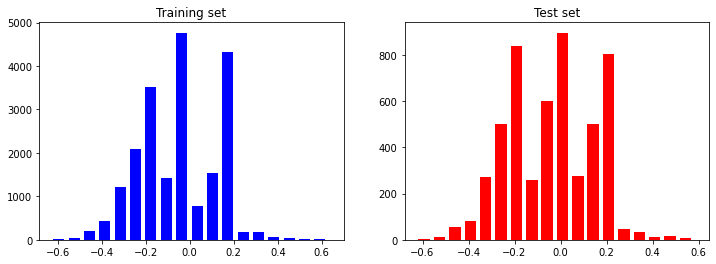

In [9]:
#Dataset split

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.20, random_state = 1)

# Check that data is valid
print("Training Samples: {}\nTest Samples: {}".format(len(X_train), len(X_test)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=18, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_test, bins=18, width=0.05, color='red')
axes[1].set_title('Test set');

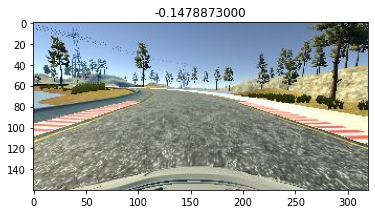

In [9]:
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show()

## Dataset preprocessing

In [10]:
#Definition of crop function

def crop(img, crop_size=60):
    """
    Crop the image (removing the sky)
    """
    new_slika = img.copy()
    cropped = new_slika[crop_size:, :, :]

    return cropped

In [11]:
#Definition of resize function

image_width = 200
image_height = 66

def resize_image(image):
    """
    Resize the image to the input shape used by the network model
    """
    resized_image = cv.resize(image, (image_width, image_height), cv.INTER_AREA)
    
    return resized_image


In [12]:
#YUV color transformation function

def yuv_color(image):
  """ 
  Change to YUV image
  """
  yuv_image = cv.cvtColor(image, cv.COLOR_RGB2YUV)

  return yuv_image

In [11]:
#Normalize data 

def normalize(image):
  image = image.astype(np.float32)
  return image/255.0

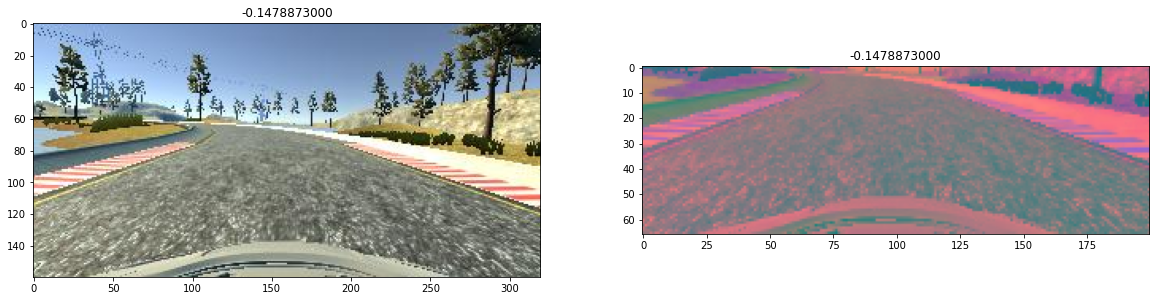

In [14]:
#Comparison of the original and the cropped image

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(yuv_color(resize_image(crop(read_image(X_train[10])))))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

# **Defining Image Augmentation Functions**



In [12]:
#Image flip function

def flip_image(img, steering_angle):
    """
    Flip the image and adjust the steering angle.
    """
    flip_img = cv.flip(img, 1)
    steering_angle = steering_angle * (-1)
    return flip_img, steering_angle

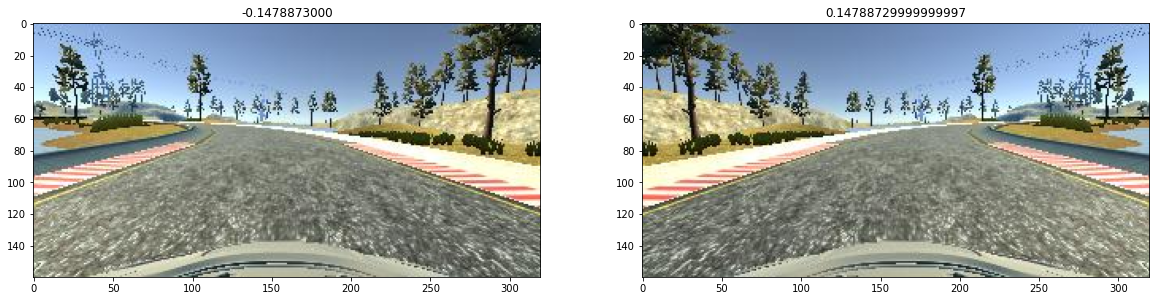

In [13]:
#Comparison of the original and the flipped image

original_image = read_image(X_train[10])
original_angle = y_train[10]

fliped_image, fliped_angle = flip_image(original_image, original_angle)

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(fliped_image)
plt.title(fliped_angle)

plt.show(block=True)

In [14]:
#Changing brigthness of image

def change_image_brightness(img, s_low=0.3, s_high=0.7):
    """
    Adjust brightness of the image.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

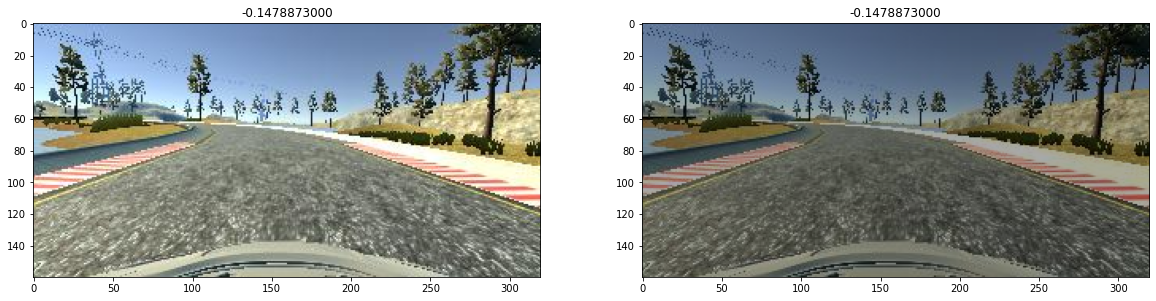

In [15]:
#Comparison of the original and image with changed brigthness

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(change_image_brightness(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

In [16]:
#Adding random shadow

def add_random_shadow(img, w_low=0.5, w_high=0.9):
    """
    Generates and adds random shadow.
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv.fillPoly(mask, poly, (0, 0, 0))
    
    return cv.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

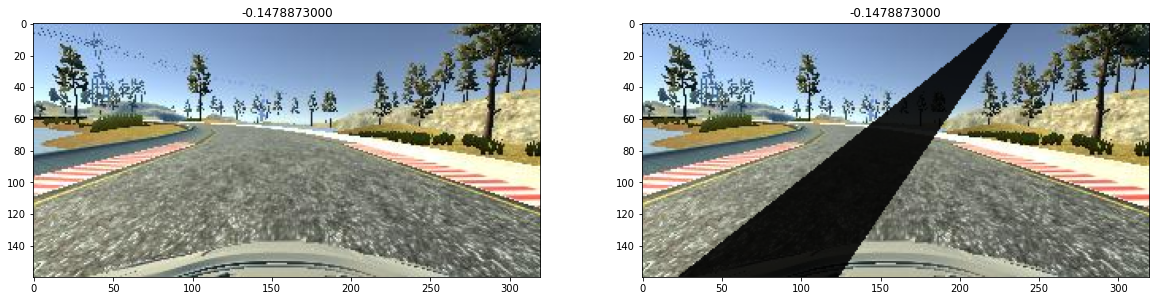

In [17]:
#Comparison of the original and image with added random shadow

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(add_random_shadow(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

In [18]:
#Adding random noise

def random_noise(image,prob=0.05):
    """
    Adds random noise to teh image.
    """
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

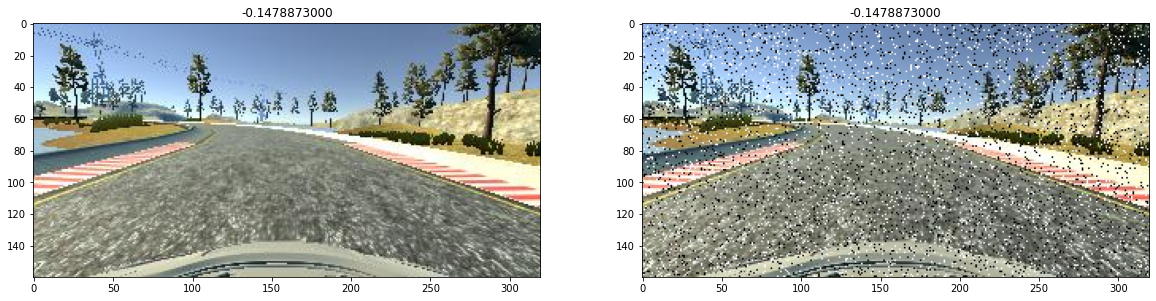

In [19]:
#Comparison of the original and image with added random noise

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(X_train[10]))
plt.title('{0:.10f}'.format(y_train[10]))
f.add_subplot(1,2, 2)
plt.imshow(random_noise(read_image(X_train[10])))
plt.title('{0:.10f}'.format(y_train[10]))
plt.show(block=True)

# **Generator**

In [20]:
def augment_image(img, angle, p=1.0):
    """
    Randomly implements augmention function on image.
    """
    aug_img = img
    
    if np.random.random_sample() <= p: 
        aug_img, angle = flip_image(aug_img, angle)
     
    if np.random.random_sample() <= p:
        aug_img = change_image_brightness(aug_img)
    
    if np.random.random_sample() <= p: 
        aug_img = add_random_shadow(aug_img)

    if np.random.random_sample() <= p:
        aug_img = random_noise(aug_img)
            
    return aug_img, angle

In [21]:
def generator(inputs, targets, batch_size = 32, is_training=True):
    """
    Creating 'generator' function for memory efficiency.
    This function shuffles the dataset, crops images, randomly implements image agmentation function only on training dataset and normalize the images.
    """
    images = inputs
    while True:
      images, targets = sklearn.utils.shuffle(images, targets)
      for i in range(0, len(images), batch_size):
          X_batch = []
          target_batch  = []
          for image, target in zip(images[i:i+batch_size], targets[i:i+batch_size]):
              #Read, crop, resize and yuv color 
              slika = read_image(image)
              slika = crop(slika)
              #slika = resize_image(slika)
              if is_training:
                #slika = yuv_color(slika)
                X_batch.append(normalize(slika))
                target_batch.append(target)
                fliped_image, angle = flip_image(normalize(slika), target)
                X_batch.append(fliped_image)
                target_batch.append(angle)
                slika, target = augment_image(normalize(slika), target, p=0.5)
              else:
                X_batch.append(normalize(slika))
                target_batch.append(target)
          yield np.array(X_batch), np.array(target_batch)

In [22]:
train_generator = generator(X_train, y_train, 32)
valid_generator = generator(X_test, y_test, 32, is_training=False)

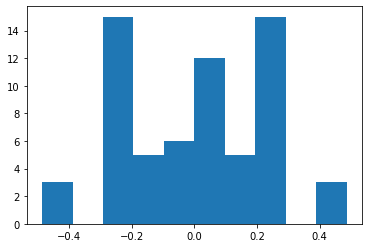

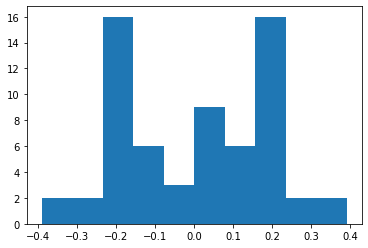

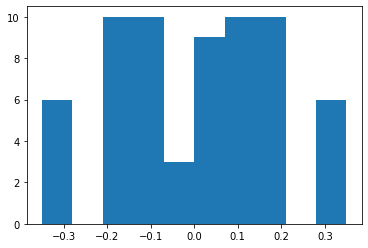

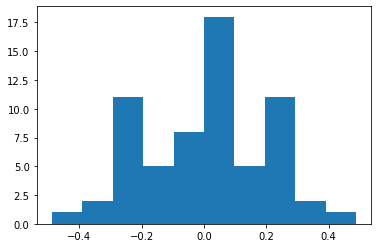

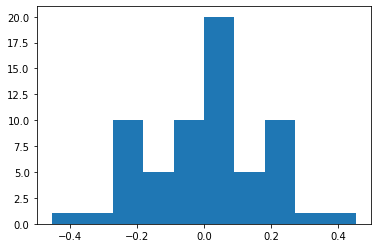

In [ ]:
#Visualzation of target per batch

for i in range(5):
   _, angle = next(train_generator)
   plt.hist(angle, bins = 10)
   plt.show()

# **Building Neural Networks**

##Model 1 architecture, compile, summary

In [63]:
model1 = Sequential()

# Input normalization layer
model1.add(Convolution2D(16, (3, 3), strides = (2, 2), input_shape=(100,320, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model1.add(Convolution2D(32, 3, 3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model1.add(Convolution2D(128, 2, 2, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model1.add(core.Flatten())

model1.add(core.Dense(100, activation='relu'))
model1.add(core.Dropout(.5))

model1.add(core.Dense(64, activation='relu'))
model1.add(core.Dropout(.25))

model1.add(core.Dense(10, activation='relu'))

model1.add(core.Dense(1))

#model compile
model1.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mse')

In [64]:
model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 49, 159, 16)       448       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 80, 16)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 8, 26, 32)         4640      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 4, 13, 32)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 2, 6, 128)         16512     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 1, 3, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 384)             

###Model checkpoint and early stopping

In [65]:
callback1 = ModelCheckpoint('best_model1.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=5)
callback_list = [callback1, callback2]

###Model training

In [66]:
history = model1.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list,
        epochs=20)

Epoch 1/20
650/650 [==============================] - 429s 659ms/step - loss: 0.0295 - val_loss: 0.0266

Epoch 00001: val_loss improved from inf to 0.02657, saving model to best_model1.pt
INFO:tensorflow:Assets written to: best_model1.pt/assets
Epoch 2/20
650/650 [==============================] - 427s 658ms/step - loss: 0.0090 - val_loss: 0.0335

Epoch 00002: val_loss did not improve from 0.02657
Epoch 3/20
650/650 [==============================] - 433s 667ms/step - loss: 0.0066 - val_loss: 0.0382

Epoch 00003: val_loss did not improve from 0.02657
Epoch 4/20
650/650 [==============================] - 426s 656ms/step - loss: 0.0055 - val_loss: 0.0403

Epoch 00004: val_loss did not improve from 0.02657
Epoch 5/20
650/650 [==============================] - 428s 660ms/step - loss: 0.0046 - val_loss: 0.0409

Epoch 00005: val_loss did not improve from 0.02657
Epoch 6/20
650/650 [==============================] - 428s 660ms/step - loss: 0.0042 - val_loss: 0.0383

Epoch 00006: val_loss did 

###Model resaults visualization

Text(0.5, 0, 'Epoch')

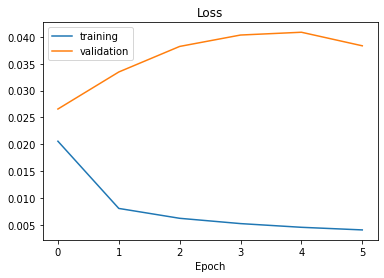

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [72]:
model1.save('model1.h5')

##Model 2 architecture, compile, summary

In [ ]:
model2 = Sequential()
# Input normalization layer
model2.add(Convolution2D(24, 2, 2, input_shape=(image_height, image_width, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(36, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(48, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(64, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Dropout(0.5))

model2.add(Convolution2D(128, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Dropout(0.5))

model2.add(core.Flatten())
model2.add(core.Dense(100, activation='relu'))
model2.add(core.Dropout(0.25))

model2.add(core.Dense(50, activation='relu'))
model2.add(core.Dropout(0.25))

model2.add(core.Dense(10, activation='relu'))

model2.add(core.Dense(1))

#model compile
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 33, 100, 24)       312       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 17, 50, 24)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 25, 36)         3492      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 13, 36)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 6, 48)          6960      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 3, 48)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 3, 64)         

###Model checkpoint and early stopping

In [ ]:
callback12 = ModelCheckpoint('best_model2.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback22 = EarlyStopping(patience=5)
callback_list_2 = [callback12, callback22]

###Model training

In [ ]:
history_2 = model2.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_2,
        epochs=30)

###Model resaults visualization

Text(0.5, 0, 'Epoch')

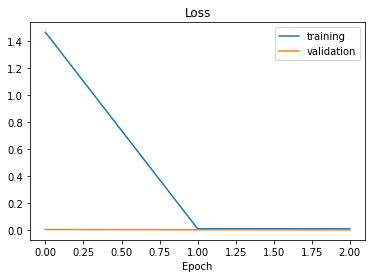

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [ ]:
model2.save('model2.h5')

##Model 3 architecture, compile, summary

In [31]:
model3 = Sequential()
model3.add(Convolution2D (32, (3, 3), strides =(2, 2), input_shape=(image_height, image_width, 3), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2)))

model3.add(Convolution2D (64, (3, 3), strides =(2,2), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2)))

model3.add(Convolution2D (128, (3, 3), strides =(2,2), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2)))

model3.add(Convolution2D (256, (3, 3), strides =(2,2), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(1,1)))

model3.add(Convolution2D (512, (3, 3), strides =(2,2), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(1,1)))
model3.add(Dropout(0.5))

model3.add(Flatten())

model3.add(Dense(1024, activation ='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(256, activation ='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))

model3.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse')

In [32]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 33, 100, 32)       896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 25, 64)         18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 12, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 3, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 2, 256)        

###Model checkpoint and early stopping

In [33]:
callback13 = ModelCheckpoint('best_model_3.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback23 = EarlyStopping(patience=5)
callback_list_3 = [callback13, callback23]

###Model training

In [35]:
history_3 = model3.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_3,
        epochs=20)

Epoch 1/20
650/650 [==============================] - 243s 306ms/step - loss: 0.0151 - val_loss: 0.0196

Epoch 00001: val_loss improved from inf to 0.01962, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 2/20
650/650 [==============================] - 201s 310ms/step - loss: 0.0046 - val_loss: 0.0189

Epoch 00002: val_loss improved from 0.01962 to 0.01894, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 3/20
650/650 [==============================] - 200s 308ms/step - loss: 0.0039 - val_loss: 0.0194

Epoch 00003: val_loss did not improve from 0.01894
Epoch 4/20
650/650 [==============================] - 198s 305ms/step - loss: 0.0036 - val_loss: 0.0222

Epoch 00004: val_loss did not improve from 0.01894
Epoch 5/20
650/650 [==============================] - 198s 305ms/step - loss: 0.0035 - val_loss: 0.0237

Epoch 00005: val_loss did not improve from 0.01894
Epoch 6/20
650/650 [==============

In [36]:
model3.save('model3_marija.h5')

###Model resaults visualization

Text(0.5, 0, 'Epoch')

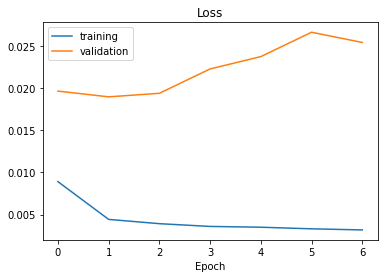

In [37]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

###Model save

In [ ]:
model3.save('model3.h5')

##Model 4 architecture, compile and summary

In [75]:
model4 = Sequential()
model4.add(Convolution2D(24, 5, 5, input_shape = (100,320,3), activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(36, 5, 5, activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(64, 2, 2, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())

model4.add(Convolution2D(128, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Convolution2D(256, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Convolution2D(512, 1, 1, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
    
model4.add(Flatten())

model4.add(Dense(250, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(100, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(50, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(1))
    
model4.compile(loss = "MSE", optimizer = Adam(learning_rate = 0.001))

In [76]:
model4.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 20, 64, 24)        1824      
_________________________________________________________________
batch_normalization_50 (Batc (None, 20, 64, 24)        96        
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 4, 12, 36)         21636     
_________________________________________________________________
batch_normalization_51 (Batc (None, 4, 12, 36)         144       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 6, 64)          9280      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 1, 3, 64)          0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 1, 3, 64)        

In [79]:
callback14 = ModelCheckpoint('best_model_4.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback24 = EarlyStopping(patience=7)
callback_list_4 = [callback14, callback24]

In [ ]:
history_4 = model4.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_4,
        epochs=20)

Text(0.5, 0, 'Epoch')

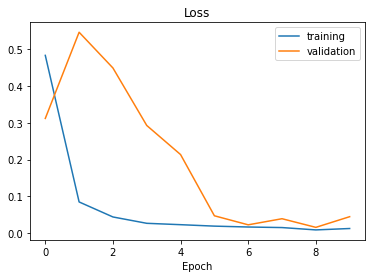

In [ ]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model4.save('model4.h5')

##Model 

In [23]:
model5 = Sequential()
# Input normalization layer
model5.add(Convolution2D(24, (5, 5), strides = (2, 2), input_shape = (100, 320, 3), activation = 'elu'))

# 5x5 Convolutional layers with stride of 2x2
model5.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='elu'))
model5.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
model5.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))

# 3x3 Convolutional layers with stride of 1x1
model5.add(Convolution2D(64, (1, 1), strides=(1, 1), activation='elu'))
model5.add(Convolution2D(128, (1, 1), strides=(1, 1), activation='elu'))

# Flatten before passing to Fully Connected layers
model5.add(Flatten())

# Three fully connected layers
model5.add(Dense(100, activation='elu'))
model5.add(Dropout(.5))
model5.add(Dense(50, activation='elu'))
model5.add(Dropout(.5))
model5.add(Dense(10, activation='elu'))
model5.add(Dropout(.5))

# Output layer with tanh activation 
model5.add(Dense(1))

adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model5.compile(optimizer="adam", loss="mse")


In [24]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 77, 24)        14424     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 37, 36)         21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 17, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 17, 64)         3136      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 17, 128)        8320      
_________________________________________________________________
flatten (Flatten)            (None, 6528)              0

In [25]:
callback15 = ModelCheckpoint('best_model_5.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback25 = EarlyStopping(patience=7)
callback_list_5 = [callback15, callback25]

In [ ]:
history_5 = model5.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_5,
        epochs=20)

Epoch 1/20
650/650 [==============================] - 1065s 2s/step - loss: 1.0259 - val_loss: 0.0113

Epoch 00001: val_loss improved from inf to 0.01133, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 2/20
650/650 [==============================] - 1041s 2s/step - loss: 0.0302 - val_loss: 0.0090

Epoch 00002: val_loss improved from 0.01133 to 0.00897, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 3/20
650/650 [==============================] - 1045s 2s/step - loss: 0.0207 - val_loss: 0.0075

Epoch 00003: val_loss improved from 0.00897 to 0.00752, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 4/20
650/650 [==============================] - 1063s 2s/step - loss: 0.0176 - val_loss: 0.0063

Epoch 00004: val_loss improved from 0.00752 to 0.00633, saving model to best_model_5.pt
INFO:tensorflow:Assets written to: best_model_5.pt/assets
Epoch 5/

In [ ]:
model5.save('model5-marija.h5')

In [1]:
model6 = Sequential()
model6.add(Convolution2D(32, (3, 3), activation='relu', input_shape = (100, 320, 3), padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.25))
model6.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.25))
model6.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
model6.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model6.add(Dropout(0.5))
model6.add(Flatten())
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(1))
model6.compile(optimizer=Adam(learning_rate=1e-4), loss = 'mse')
model6.summary()

NameError: ignored

In [68]:
callback16 = ModelCheckpoint('best_model_6.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback26 = EarlyStopping(patience=3)
callback_list_6 = [callback16, callback26]

In [69]:
history_6 = model6.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_6,
        epochs=20)

Epoch 1/20
650/650 [==============================] - 449s 688ms/step - loss: 1.1587 - val_loss: 0.0324

Epoch 00001: val_loss did not improve from 0.01894
Epoch 2/20
650/650 [==============================] - 448s 690ms/step - loss: 0.0246 - val_loss: 0.0301

Epoch 00002: val_loss did not improve from 0.01894
Epoch 3/20
650/650 [==============================] - 446s 687ms/step - loss: 0.0150 - val_loss: 0.0316

Epoch 00003: val_loss did not improve from 0.01894
Epoch 4/20
650/650 [==============================] - 447s 689ms/step - loss: 0.0136 - val_loss: 0.0327

Epoch 00004: val_loss did not improve from 0.01894
Epoch 5/20
650/650 [==============================] - 453s 698ms/step - loss: 0.0125 - val_loss: 0.0343

Epoch 00005: val_loss did not improve from 0.01894
Epoch 6/20
650/650 [==============================] - 449s 691ms/step - loss: 0.0118 - val_loss: 0.0357

Epoch 00006: val_loss did not improve from 0.01894
Epoch 7/20
409/650 [=================>............] - ETA: 2:45 

KeyboardInterrupt: ignored

In [41]:
model6.save('model6-marija.h5')

In [50]:
model7 = Sequential()
  
model7.add(Convolution2D(32, 3, 3, input_shape = (66, 200, 3), padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.5))

model7.add(Convolution2D(64, 3, 3, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.5))

model7.add(Convolution2D(128, 3, 3, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(1,1)))
model7.add(Dropout(0.5))
    
model7.add(Convolution2D(256, 3, 3, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(1,1)))
model7.add(Dropout(0.5))

    
    # Flattening the output of last convolutional layer before entering fully connected phase
model7.add(Flatten())
    
    # Fully connected layers    
model7.add(Dense(1024, activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))

    
model7.add(Dense(128, activation='relu'))
model7.add(BatchNormalization())
    
model7.add(Dense(64, activation='relu'))
model7.add(BatchNormalization())

    
model7.add(Dense(16, activation='relu'))
model7.add(BatchNormalization())
    
    # Output layer
model7.add(Dense(1))
    
model7.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
model7.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 22, 67, 32)        896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 22, 67, 32)        128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 11, 33, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 11, 33, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 4, 11, 64)         18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 4, 11, 64)         256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 5, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [51]:
callback17 = ModelCheckpoint('best_model_7.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback27 = EarlyStopping(patience=3)
callback_list_7 = [callback17, callback27]

In [52]:
history_7 = model6.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_3,
        epochs=20)

Epoch 1/20
650/650 [==============================] - 204s 315ms/step - loss: 0.0032 - val_loss: 0.0349

Epoch 00001: val_loss did not improve from 0.01894
Epoch 2/20
186/650 [=======>......................] - ETA: 2:28 - loss: 0.0032

KeyboardInterrupt: ignored

##Preparating the X_train dataset for predictions

In [ ]:
def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = read_image(image)
    image = crop(image)
    image = resize_image(image)
    image = normalize(image)

    return image

In [ ]:
# Converting the X_test dataset for predictions

X_test_ = np.array(list(map(preprocess, X_test)))

In [ ]:
mode1_prediction = model1.predict(X_test_)
mode2_prediction = model2.predict(X_test_)
mode3_prediction = model3.predict(X_test_)
mode4_prediction = model4.predict(X_test_)
mode5_prediction = model5.predict(X_test_)

In [ ]:
mode1_prediction = mode1_prediction.reshape(1,-1)
mode2_prediction = mode2_prediction.reshape(1,-1)
mode3_prediction = mode3_prediction.reshape(1,-1)
mode4_prediction = mode4_prediction.reshape(1,-1)
mode5_prediction = mode5_prediction.reshape(1,-1)

In [ ]:
model1_pred_abs = np.abs(y_test-mode1_prediction) 
model2_pred_abs = np.abs(y_test-mode2_prediction) 
model3_pred_abs = np.abs(y_test-mode3_prediction) 
model4_pred_abs = np.abs(y_test-mode4_prediction) 
model5_pred_abs = np.abs(y_test-mode5_prediction) 

In [ ]:
threshold = 0.7

In [ ]:
is_accurate_model1 = np.where(model1_pred_abs<threshold, 1, 0)
is_accurate_model2 = np.where(model2_pred_abs<threshold, 1, 0)
is_accurate_model3 = np.where(model3_pred_abs<threshold, 1, 0)
is_accurate_model4 = np.where(model4_pred_abs<threshold, 1, 0)
is_accurate_model5 = np.where(model5_pred_abs<threshold, 1, 0)

In [ ]:
accuracy_score_model1 = np.mean(is_accurate_model1)
accuracy_score_model2 = np.mean(is_accurate_model2)
accuracy_score_model3 = np.mean(is_accurate_model3)
accuracy_score_model4 = np.mean(is_accurate_model4)
accuracy_score_model5 = np.mean(is_accurate_model5)